<a href="https://colab.research.google.com/github/daniribeirof/UB_DS-ML_3_Image-classification/blob/main/MiniProject_Classification_Postgrau_DanielaRibeiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Project
Outline:

*   The Data
*   Setting Up the MLflow interface
*   Problem 1: Binary Classification
    - Refactor the data. Unbalanced dataset.
    - Train a model
    - Evaluate
    - Fixing the unbalance
    - Retrain the model
    - Improvements
*   Problem 2: Multiclass Classification
    - Train a model
    - Evaluate
*   Check the results using MLflow
*   (Optional): CIFAR10


Before start running the notebook make sure that in the option **GPU** is selected:
<br> `Runtime -> Change runtime -> Hardward acceleration`<br>  

# **DATASET**

The MNIST fashion dataset contains black and white images of 10 different kinds of clothing. The goal is to classify each of the images in its corresponding class, although we are going to modify the problem a little to make it more interesting.

* In the first problem we are going to separate one of the classes (**Shirt**, for example) and we are going to train a classifier that separates images of type Shirt and images that do not correspond to that class. Here we will see one of the most common problems when programming classifiers in the world of Machine and Deep Learning.

* In the second problem, we are going to solve the classic problem, that is to say, we are going to use the 10 categories and we will try to assign to each image its corresponding category.
<br>
<br>   

---
An example of each class from the dataset in seen on the image below:


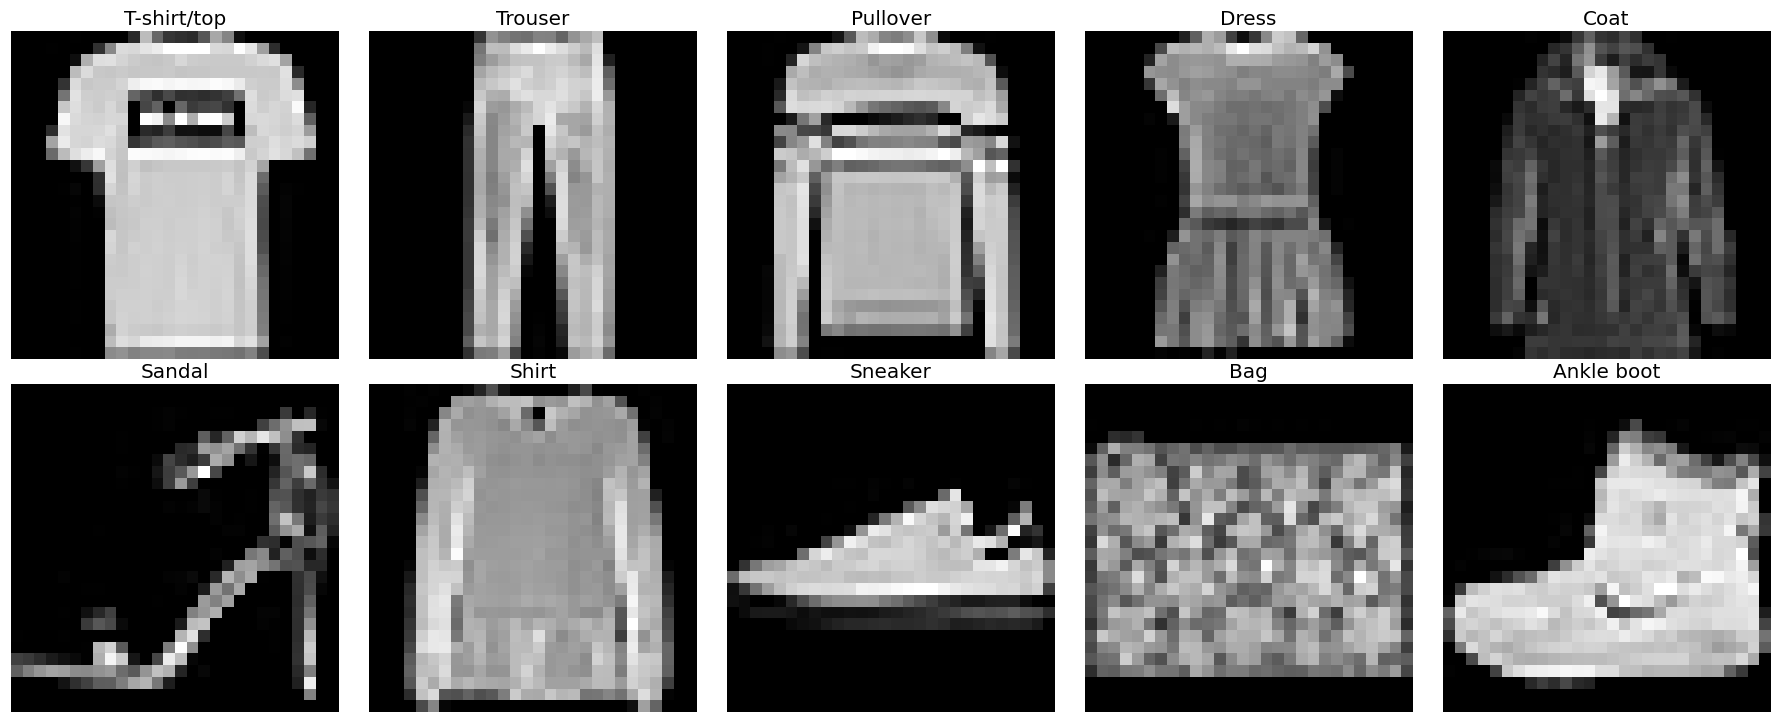

## Loading the data ...

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Since these images are black and white, they only have one 'channel'. We repeat the
# channel three times to convert them into RGB images.
x_train = np.repeat(np.expand_dims(x_train, -1), 3, -1)
x_test = np.repeat(np.expand_dims(x_test, -1), 3, -1)

# Printing the shapes we can observe that there are 60k images in the training set and 10k images in the validation set.
print(x_train.shape, x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 3) (10000, 28, 28, 3)


In [ ]:
print(type(tf.keras.datasets.fashion_mnist.load_data()))
print(len(tf.keras.datasets.fashion_mnist.load_data()))

print(type(tf.keras.datasets.fashion_mnist.load_data()[0]))
print(len(tf.keras.datasets.fashion_mnist.load_data()[0]))

<class 'tuple'>
2
<class 'tuple'>
2


In [ ]:
class2label = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

> As you can see, this function already returns a training set and a validation set. This is important because then all the solutions proposed in this dataset use the same partition of the data and the comparisons are fair.

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

We can see that we have 6000 examples of each class. It is therefore, a balanced dataset.

## MLflow interface

We are going to log all the experiments we perform. To this end, first we need to start the MLflow tracking server.
If you are running this notebook on Colab, remember to add you NGROK_AUTH_TOKEN. If you are running this notebook on a local machine, there is no need to use ngrok, just type `mlflow ui --port 5000` on a terminal to start the mlflow server.

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2LjsgwxVKBPlDOsDZAARtnnXSnC_54zt2EzWeWK9jRFkgDVD6"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


ERROR:pyngrok.process.ngrok:t=2023-04-14T14:32:28+0000 lvl=eror msg="failed to auth" obj=tunnels.session err="Your account is limited to 1 simultaneous ngrok agent session.\nActive ngrok agent sessions in region 'us':\n  - ts_2OQANJjGs2YWlkSTzUon4HJnGSj (92.178.222.6)\r\n\r\nERR_NGROK_108\r\n"


PyngrokNgrokError: ignored

# **Problems**

## **Problem 1**: Binary Classification

In the binary classification problem we will try to identify whether each image is a shirt or not (shirt, just because it was the class previously selected to be detected). In the first proposed exercice, you will need to program this separation of classes as well as to generate their labels respectively. From now on, you will find the exercies with an explanation in hashtags and also with a guideline of which lines need to be filled. Otherwise, you just need to read and understand carefully the code and explanations.

### 1. Pre-processing the data

In [ ]:
import mlflow
mlflow.set_experiment('Binary Classification')

In [ ]:
# AUXILIAR FUNCTION
# This function is defined to better display images. It has no relevance for solving the problem.

def plot_frames(images, columns=5, show_titles=True, figsize=None, title_fontsize=10):
    columns = min(columns, len(images))
    nrows = len(images)//columns+int(len(images)%columns > 0)

    # Set default figsize if not provided
    figsize = (columns*5,nrows*5) if figsize is None else figsize
    fig, axs = plt.subplots(nrows, columns, figsize = figsize)
    axs = axs.flatten()

    for idx_ax in range(len(images)):
        im2show = images[idx_ax][0] if len(images[idx_ax])==2 else images[idx_ax]
        axs[idx_ax].imshow(im2show)
        axs[idx_ax].axis('off')

        if show_titles:
            axs[idx_ax].set_title(images[idx_ax][1], fontsize=title_fontsize)

    for id_ax in range(len(images), len(axs)):
        fig.delaxes(axs[id_ax])

    plt.tight_layout()
    plt.show()

In order to test this function, we are going to plot 10 images with their labels:

In [ ]:
rd = np.random.choice(range(len(x_train)), 10, replace=False)
images_plot, labels_plot = x_train[rd], y_train[rd]

labels_names = [class2label[n] for n in labels_plot]

plot_frames(list(zip(images_plot, labels_names)), columns=10, title_fontsize=20)

Now, we are going to modify the data labels a bit. As we have seen, we have 6000 examples of each class. To make the problem a little more complicated, we are going to change the labels of all the classes except one and we are going to reduce the number of examples of that class.

In [ ]:
x_train.shape

In [ ]:
np.where(y_train==6, 1, 0).sum()

In [ ]:
to_classify = 6
samples_small_class = 300

##########################################################
# EXERCICE 1: Transform the dataset by creating 4 new variables: 'new_x_train, new_y_train, new_x_test, new_y_test'.
#             This new dataset has to contain only 2 labels (0 and 1) being 1 all the images that belong to the 'to_classify'
#             class and 0 all the images that don't belong to it.
#             Moreover, reduce the number of examples of the positive class keeping exactly 'samples_small_class' images.
##########################################################

# Train: 300 shirts (label 1) & 54000 others (label 0) / Test: 1000 shirts & 9000 others
y_six_id = np.random.choice(np.where(y_train==to_classify)[0], samples_small_class, replace=False)
y_other_id = np.where(y_train!=to_classify)[0]

# New labels
new_y_train = np.concatenate((y_train[y_six_id], y_train[y_other_id]))
new_y_train = np.where(new_y_train==to_classify, 1, 0)
new_y_test = np.where(y_test==to_classify, 1, 0)

# New images
new_x_train = np.concatenate((x_train[y_six_id], x_train[y_other_id]))
new_x_test = x_test

In [ ]:
np.unique(y_train, return_counts=True)

In [ ]:
print(np.unique(new_y_train, return_counts=True))
print(np.unique(new_y_test, return_counts=True))
print(new_x_train.shape)
print(new_x_test.shape)

Ok! So now we have 54000 samples of one class and 300 of the other class, let's try to train a model.

### 2. Defining the model
We are defining a model with four layers:
*  First, an **Input** where we can specify the shape of the images that will be entered to the model.
*  Then, since the images are of shape 28x28 we are resizing them to 32x32 with the **Resizing** layer. This is the smallest shape the next layer allows.
*  Then, the model itself. In this case we are using an **EfficientNetB0**.
*  Finally, a layer to classify (**Dense** layer). Since we are trying to predict 0/1, we only need one output.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Resizing

# Input shape
inp = Input(shape=(28, 28, 3))

# Resize the data to 32x32 pixels
resized = Resizing(32, 32)(inp)

# Load a model. You can try different models from: https://keras.io/api/applications/
# Take this part as a black-box if you want for the moment, it is a magim model that recieves images as input
# and outputs a vector that contains the information of the image.
base_model = EfficientNetB0(include_top=False, input_shape=(32, 32, 3), pooling='avg')
eff = base_model(resized)

# To classify, we add a sigmoid function so the output is pushed towards
# the value 1 (if >0.5) or towards the value 0 (if <0.5)
out = Dense(1, activation='sigmoid')(eff)  #sigmoid solo para clasificacion binaria
model = Model(inputs=inp, outputs=out)

# Define the loss and the optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Here we can inspect the model. Observe that the data inputed to the model are images of size (28x28x3), then they are reshaped to size (32x32x32) and inputed to the efficientnetb0 model, that outputs a single vector (embedding) per image of size 1280. This vector is agregated into a single value using a Dense layer (Multi-Layer perceptron).

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, rankdir='LR', show_shapes=True)

We can also check the number of parameters of each of the previous layers with the **summary** function.

In [ ]:
model.summary()

### 3. Do the training

With the model definition, now we can train the model on the train data. Check that we are using also the test data to check the performance of the model on unseen data. By doing that, we can check if the model is overfitting the training data.

In [ ]:
##########################################################
# EXERCICE 2: Fit the model on the new data and use the test set as validation
#             You can train for 5 epochs and set the batch size to 1024.
#             Assign the call to the variable 'history' so we can visualize the results later.
##########################################################

history = model.fit(new_x_train, new_y_train, batch_size=1024, epochs=5, validation_data=(new_x_test, new_y_test), shuffle=True)

We trained the first model! Let's check the results.

### 4. Evaluate the model (Inference)

Inference is the process of evaluating data with a trained model. To see if our model has trained correctly and is able to classify data that it has not seen, we will use the test set.

Next, we define a function that allows us to show the learning curve. If the value of 'loss' decreases, it means that we are making fewer errors and, therefore, we are learning. For a model to be trained correctly the value of 'loss' has to decrease for both training and validation data.

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].plot(history.history['loss'], label='train_loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Learning curve (Loss)')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='train_accuracy')
    axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Learning curve (Accuracy)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from matplotlib import pyplot as plt
plot_history(history)

Hmmm... It seems that our model is not training properly. Why do you think this is?

Let's plot some predictions:

In [ ]:
N = 20
columns = 10

# Select N/2 examples with class 0 and N/2 examples with class 1
std = sorted(zip(new_x_test, new_y_test), key=lambda x: x[1])
filt = std[:N//2] + std[-N//2:]
xp, _ = zip(*filt)

# The title contains the real label and the predicted one
titles = [f'Real:{y} \nPredicted:{round(model.predict(np.expand_dims(x, 0))[0][0])}' for x,y in filt]
plot_frames(list(zip(xp, titles)), columns=columns, figsize=(20, 5))

It seems that it predicts for almost all images the label 0. Let's check it with the confusion matrix

313/313 [==============================] - 4s 13ms/step


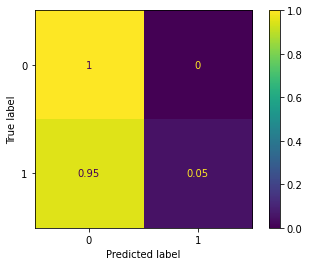

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

pred_y_test = model.predict(new_x_test)
ConfusionMatrixDisplay.from_predictions(new_y_test, np.round(pred_y_test).flatten(), normalize='true');

In [ ]:
##########################################################
# EXERCICE 3: Check the figure with the predictions and the ConfusionMatrix
#             displayed in the previous cell.
#             Can you explain what is happening? Is the model learning?
##########################################################

Almost all predictions made by the model were 0. As the data has a much larger amount of images of classes 0 compared to classes 1, the model is not learning properly.

### 5. Fixing the unbalance
Now that we know that our model is always predicting the least represented class, let's try to solve it. First we can play with the loss function.

As you know, the loss function calculates the error during training and using the gradient, we modify the weights of the model to reduce the error. In that function, by default, each sample of our data has the same weight and penalizes the same if we misclassify it.
One way to try to train with an unbalanced dataset is to change that and give more penalty if we misclassify a sample of the least represented class.

Let's calculate that weight to give to the loss function.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

##########################################################
# EXERCICE 4: Investigate how to use the 'compute_class_weight' function
#             to get the weights for the two classes in a 'balanced' way.
#             We need to create a dictionary that stores the weight per class
#             If done properly, this dictionary should be: {0: 0.5027777777777778, 1: 90.5}
##########################################################

weights = compute_class_weight(class_weight='balanced', classes=np.unique(new_y_train), y=new_y_train)
dct_weights = dict(zip([0,1],weights))
print(dct_weights)

{0: 0.5027777777777778, 1: 90.5}


As the dataset is very unbalanced, the weights to be given to the two classes are very different. In this case, misclassifying a class 0 data will "penalize" ~0.5 while misclassifying a class 1 data will "penalize" ~90. That means that class 1 data has a penalty of 180 times more than class 0 data.

## 6. Retrain the model

All right, let's train the model again with these weights. When we call the 'fit' function, we can pass it the dict we have created. So, we will use these weights in the loss function.

In [ ]:
##########################################################
# EXERCICE 5: (5.1) Retrain the model as done in the previous steps but adding the class weights into the fit function.
#             This will, automatically, weight the loss function to penalize higher if the model missclassifies
#             examples of the low-represented class.
#
#             (5.2) Show the confusion matrix. Have we improved?
#
#             (5.3) Show the learning curves
##########################################################

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
history = model.fit(new_x_train, new_y_train, batch_size=1024, epochs=15, validation_data=(new_x_test, new_y_test), shuffle=True, class_weight=dct_weights, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/15
54/54 [==============================] - 11s 200ms/step - loss: 0.1031 - accuracy: 0.9462 - val_loss: 0.2198 - val_accuracy: 0.9376
Epoch 2/15
54/54 [==============================] - 10s 186ms/step - loss: 0.0986 - accuracy: 0.9492 - val_loss: 0.3444 - val_accuracy: 0.8786
Epoch 3/15
54/54 [==============================] - 10s 191ms/step - loss: 0.1096 - accuracy: 0.9476 - val_loss: 0.2445 - val_accuracy: 0.9282
Epoch 4/15
54/54 [==============================] - 10s 185ms/step - loss: 0.0710 - accuracy: 0.9637 - val_loss: 0.2718 - val_accuracy: 0.9376
Epoch 5/15
54/54 [==============================] - 10s 195ms/step - loss: 0.0519 - accuracy: 0.9759 - val_loss: 0.3292 - val_accuracy: 0.9350
Epoch 6/15
54/54 [==============================] - 10s 186ms/step - loss: 0.0815 - accuracy: 0.9603 - val_loss: 0.3062 - val_accuracy: 0.9195


1/1 [==============================] - 0s 33ms/step


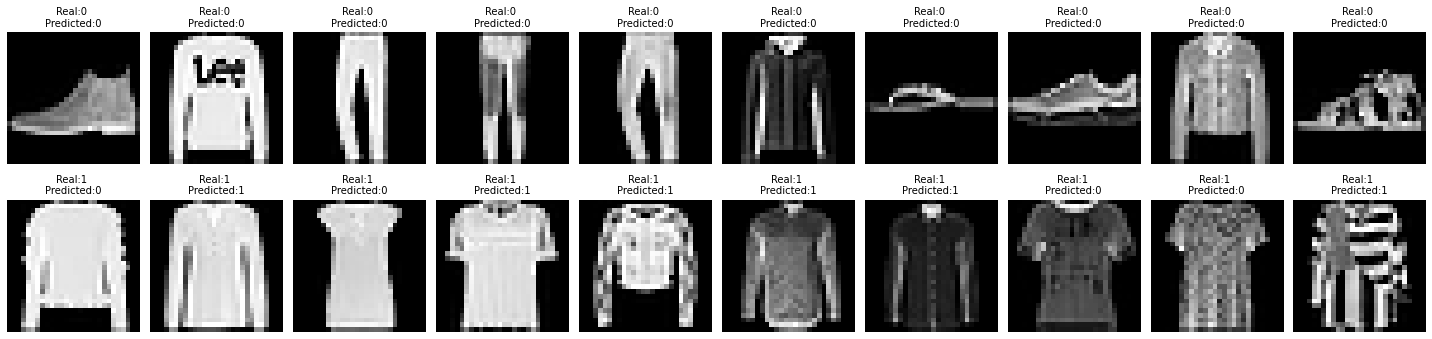

In [ ]:
N = 20
columns = 10

std = sorted(zip(new_x_test, new_y_test), key=lambda x: x[1])
filt = std[:N//2] + std[-N//2:]
xp, _ = zip(*filt)

titles = [f'Real:{y} \nPredicted:{round(model.predict(np.expand_dims(x, 0))[0][0])}' for x,y in filt]
plot_frames(list(zip(xp, titles)), columns=columns, figsize=(20, 5))

313/313 [==============================] - 4s 13ms/step


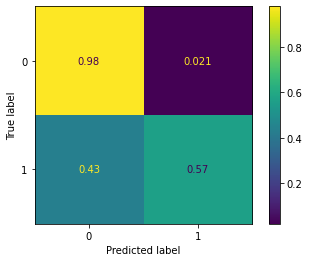

In [ ]:
pred_y_test = model.predict(new_x_test)
ConfusionMatrixDisplay.from_predictions(new_y_test, np.round(pred_y_test).flatten(), normalize='true');

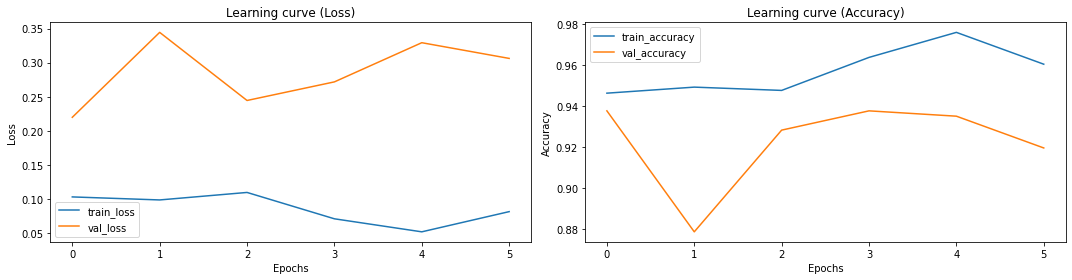

In [ ]:
plot_history(history)

Good! We can see that we have improved with the use of these weights. Still, the least represented class is difficult to classify correctly.

In [ ]:
##########################################################
# EXERCICE 6: Investigate further and repeat the previous exercice using a different model.
#             There is no need to improve the previous results, just play around.
##########################################################

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
base_model = EfficientNetB2(include_top=False, input_shape=(32, 32, 3), pooling='avg')
eff = base_model(resized)

out = Dense(1, activation='sigmoid')(eff)
model = Model(inputs=inp, outputs=out)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

31790344/31790344 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(new_x_train, new_y_train, batch_size=1024, epochs=15, validation_data=(new_x_test, new_y_test), shuffle=True, class_weight=dct_weights, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/15
54/54 [==============================] - 26s 486ms/step - loss: 0.5545 - accuracy: 0.6295 - val_loss: 0.3080 - val_accuracy: 0.9001
Epoch 2/15
54/54 [==============================] - 15s 277ms/step - loss: 0.3163 - accuracy: 0.8382 - val_loss: 0.2613 - val_accuracy: 0.9067
Epoch 3/15
54/54 [==============================] - 15s 273ms/step - loss: 0.2366 - accuracy: 0.8876 - val_loss: 0.2731 - val_accuracy: 0.9001
Epoch 4/15
54/54 [==============================] - 15s 277ms/step - loss: 0.1938 - accuracy: 0.9015 - val_loss: 0.2947 - val_accuracy: 0.9183
Epoch 5/15
54/54 [==============================] - 15s 284ms/step - loss: 0.1423 - accuracy: 0.9342 - val_loss: 0.2321 - val_accuracy: 0.9226
Epoch 6/15
54/54 [==============================] - 15s 272ms/step - loss: 0.1329 - accuracy: 0.9372 - val_loss: 0.2465 - val_accuracy: 0.9303
Epoch 7/15
54/54 [==============================] - 15s 280ms/step - loss: 0.1240 - accuracy: 0.9416 - val_loss: 0.2142 - val_accuracy: 0.9345

313/313 [==============================] - 9s 16ms/step


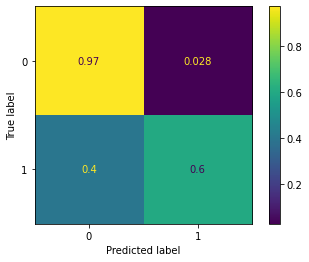

In [ ]:
pred_y_test = model.predict(new_x_test)
ConfusionMatrixDisplay.from_predictions(new_y_test, np.round(pred_y_test).flatten(), normalize='true');

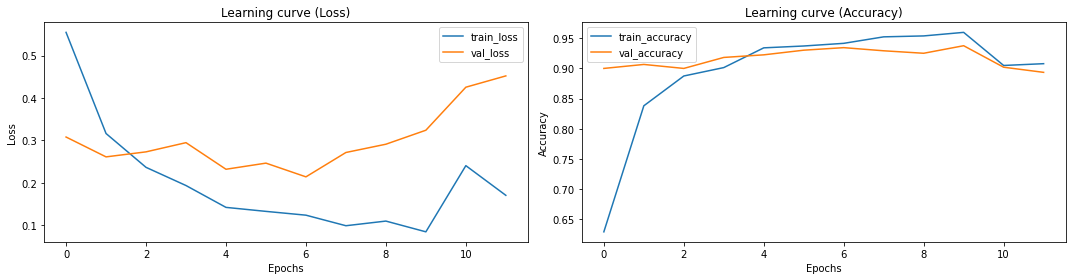

In [ ]:
plot_history(history)

## **Problem 2**: Multiclass classification

Now we will deal with the original problem, this is, to classify all the images into one of the 10 classes.

In [ ]:
# Let's create a dedicated experiment for it
mlflow.set_experiment('Multiclass Classification')

2023/03/17 12:14:38 INFO mlflow.tracking.fluent: Experiment with name 'Multiclass Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/252411566178263594', creation_time=1679055278207, experiment_id='252411566178263594', last_update_time=1679055278207, lifecycle_stage='active', name='Multiclass Classification', tags={}>

In [ ]:
class2label = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

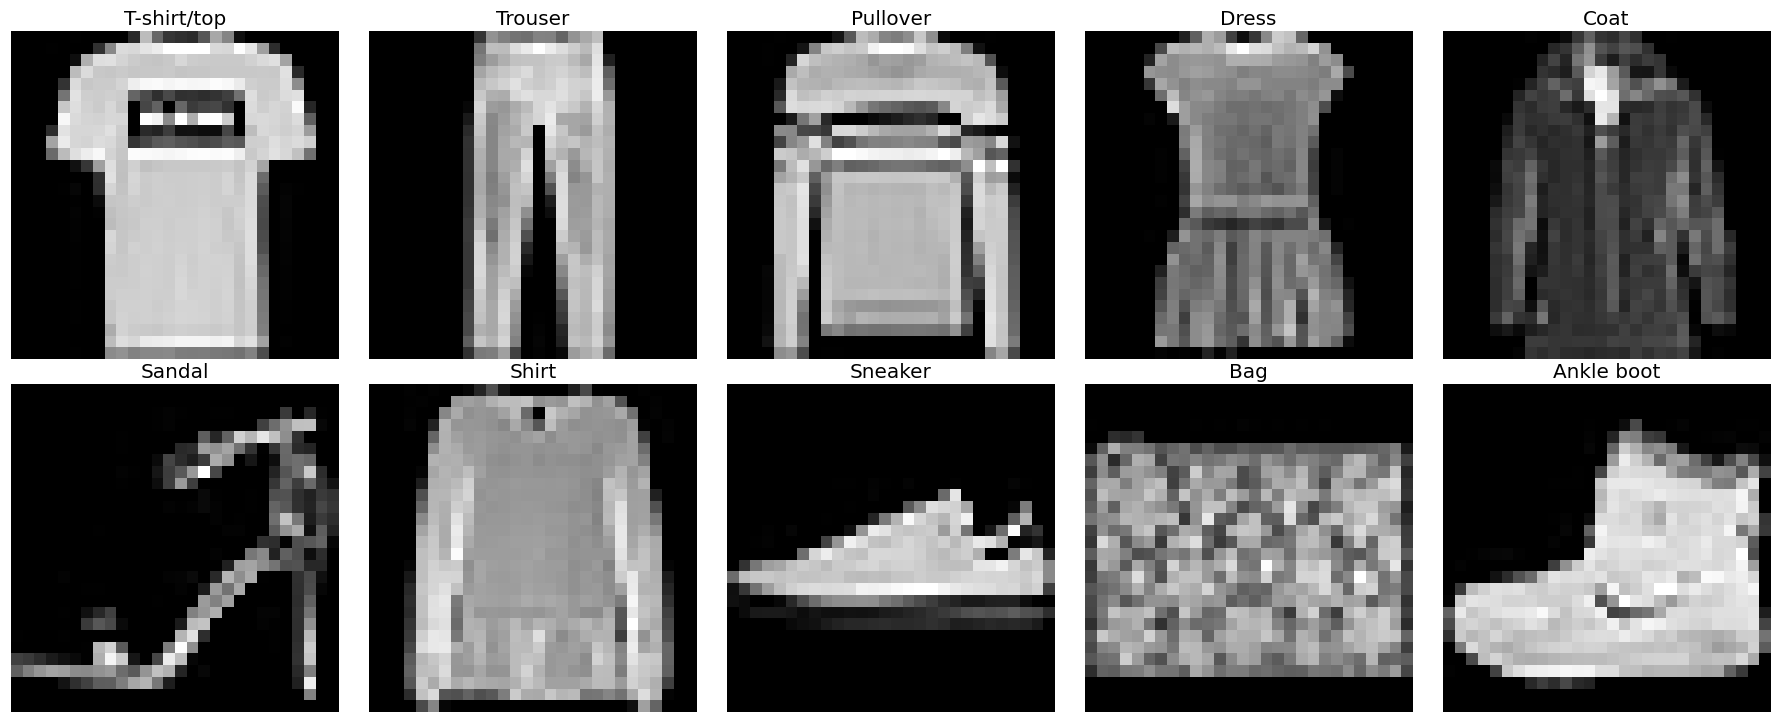

The model we use is almost identical to the model we used for the binary case. The only difference is that now we classify into 10 classes so we need the output of the model to be a vector of 10 positions. Thus, to indicate that an example is of class 0 we will use the vector [1,0,0,0,0,0,0,0,0,0] and in the same way, if it were of class 2 we would use the vector [0,1,0,0,0,0,0,0,0,0].
The last activation function is also different. While in the binary case we were using a sigmoid that returns values between 0 and 1, now we need a function that acts on a vector and not only on a value. What the softmax function does is to normalize the vector (so that the 10 positions add up to 1) and extreme the differences between the values using the exponential function. Thus, the result approximates the vector of zeros and ones that we have explained.

In [ ]:
from tensorflow.keras.utils import to_categorical

##########################################################
# EXERCICE 7: Us the to_categorical function to transform the variables
#             y_train, y_test into two new variables with the one-hot-encoding performed.
##########################################################

cat_y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
cat_y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [ ]:
# Input
inp = Input(shape=(28, 28, 3))

# Resize
resized = Resizing(32, 32)(inp)

# Model
base_model = EfficientNetB0(include_top=False, input_shape=(32, 32, 3), pooling='avg')
eff = base_model(resized)

# Classification layer using a softmax with 10 outputs
out = Dense(10, activation='softmax')(eff)
model = Model(inputs=inp, outputs=out)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
##########################################################
# EXERCICE 8: Do you see the differences between this model and the one we used in the binary classification?
#             Explain the difference between using a sigmoid/softmax in the last layer.
##########################################################

We use sigmoid for binary classification methods where we only have 2 classes. SoftMax is used to multiclass problems.

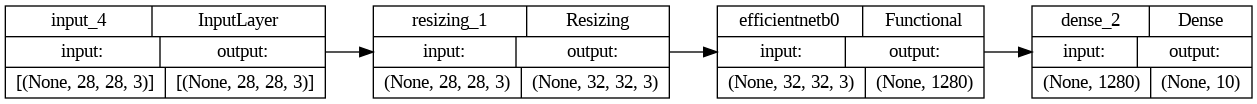

In [ ]:
plot_model(model, rankdir='LR', show_shapes=True)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 4,020,358
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
history = model.fit(x_train, cat_y_train, validation_data=(x_test, cat_y_test),
                    epochs=25, batch_size=1024,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/25
59/59 [==============================] - 50s 265ms/step - loss: 0.5553 - accuracy: 0.8074 - val_loss: 0.8397 - val_accuracy: 0.7348
Epoch 2/25
59/59 [==============================] - 11s 187ms/step - loss: 0.2512 - accuracy: 0.9080 - val_loss: 0.4651 - val_accuracy: 0.8414
Epoch 3/25
59/59 [==============================] - 12s 198ms/step - loss: 0.1929 - accuracy: 0.9293 - val_loss: 0.4148 - val_accuracy: 0.8523
Epoch 4/25
59/59 [==============================] - 11s 187ms/step - loss: 0.1551 - accuracy: 0.9418 - val_loss: 0.3880 - val_accuracy: 0.8655
Epoch 5/25
59/59 [==============================] - 11s 185ms/step - loss: 0.1267 - accuracy: 0.9533 - val_loss: 0.4011 - val_accuracy: 0.8654
Epoch 6/25
59/59 [==============================] - 11s 185ms/step - loss: 0.1076 - accuracy: 0.9599 - val_loss: 0.3945 - val_accuracy: 0.8862
Epoch 7/25
59/59 [==============================] - 11s 195ms/step - loss: 0.0866 - accuracy: 0.9683 - val_loss: 0.4325 - val_accuracy: 0.8693

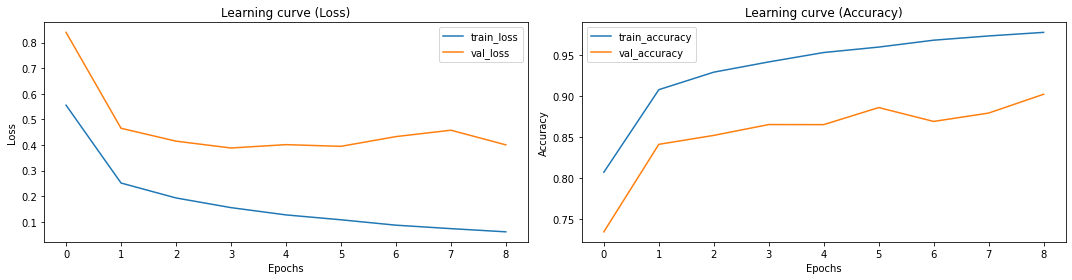

In [ ]:
plot_history(history)

313/313 [==============================] - 5s 11ms/step


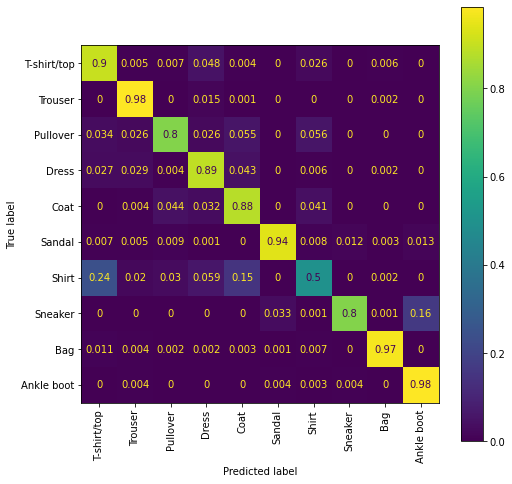

In [ ]:
pred_y_test = model.predict(x_test).argmax(-1).flatten()
fig = plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_test, pred_y_test, display_labels=class2label.values(), xticks_rotation='vertical',
                                        normalize='true', ax=fig.gca());

# (Optional): The CIFAR10 Dataset

In [ ]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()